In [1]:
import warnings
warnings.filterwarnings('ignore')

This notebook requires the following libraries: `pandas`, `scikit-learn`, `pystan`, `fbprophet`, `xlrd`

# Introduction to Machine Learning at the NHS

`Machine Learning`: we build a model of our data (an "approximation") that can be used to generate predictions in the future. To do so we use an algorithm that can learn relationships from the data.

Machine learning can be divided into multiple categories, depending on the algorithms and the type of data we use. Here we will cover two examples of `Supervised Learning` - one is a regression problem, the other a time-series one.

`Supervised Learning`refers to a problem where the data is labelled - we can show the algorithms examples of what we expect.

## What is regression

- Same as linear regression at school: we want to find the relationship between x and y

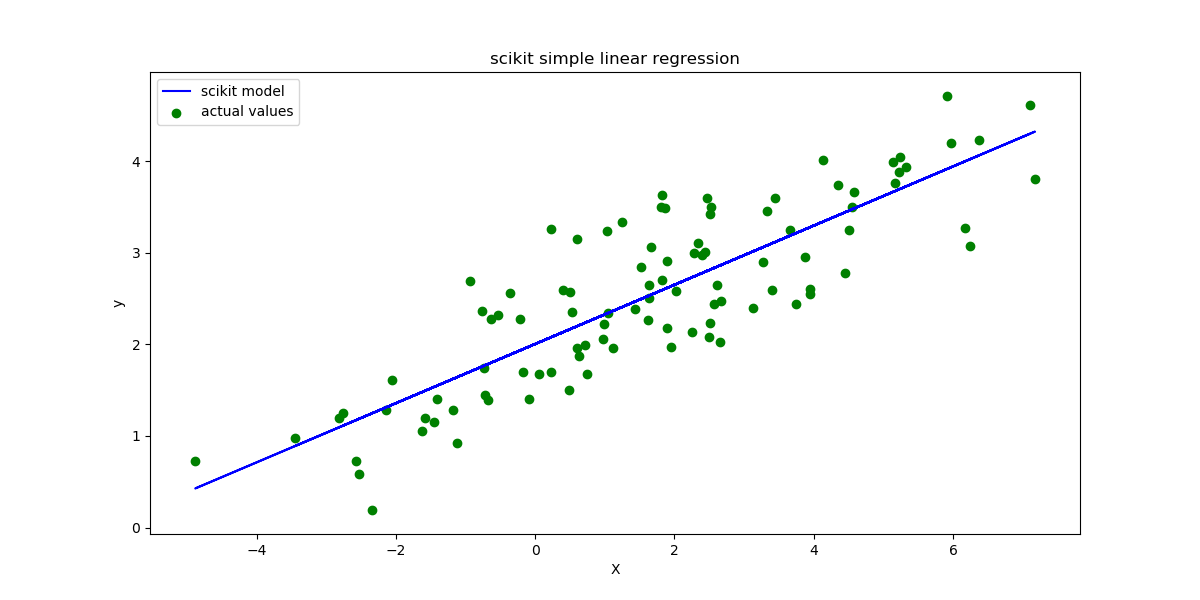

But in Machine Learning:
- x isn't just one value, it can have multiple dimensions (x1, x2, ...)
- We don't need a traight line, it can be any function
- We want to approximate the relationship between y (the outcome) and X

## How are time-series different

- Here our outcome `y` is not depending on different characteristics `x`
- Instead it only depends on past values of itself
- In other words, we want to predict future values of y based only on previous values of itself

## Example 1: Regression

For this example we will use the `NHS Payments to General Practice England` dataset. It contains information about general practices and how much NHS Payment they received in the year 2020-2021. Our goal will be to see if we can use characteristics of practices to predict how much payment they received.

This can be used either to predict payment for future practices (before we know it), or to analyse the relationship that links practices to the amount of payment they receive.

The dataset can be download from: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-payments-to-general-practice/england-2020-21

### Loading the dataset

First we will import that `pandas` library and use it to load the dataset.

Note: we have two dates in the csv, so we add them as `parse_dates` argument to ensure they are read as dates.

In [81]:
import pandas as pd

df = pd.read_csv("data/nhspaymentsgp-20-21-prac-csv.csv", 
                 parse_dates=["Practice Open Date", "Practice Close Date"])

Let's take a quick look at the information available:

In [82]:
df.shape

(6808, 68)

In [84]:
df.columns

Index(['NHS England (Region) code', 'NHS England (Region) Name', 'CCG Code',
       'CCG NAME', 'PCN Code', 'PCN Name', 'Practice Code', 'Practice Name',
       'Practice Address', 'Practice Postcode', 'Practice Open Date',
       'Practice Close Date', 'Contract Type', 'Dispensing Practice',
       'Practice type', 'Practice Rurality', 'Atypical characteristics',
       'Number of Registered Patients (Last Known Figure)',
       'Number of Weighted Patients (Last Known Figure)',
       'Average payments per registered patient',
       'Average payments per weighted patient', 'Global Sum',
       'MPIG Correction factor', 'Balance of PMS Expenditure',
       'Total QOF Payments', 'Childhood Vaccination and Immunisation Scheme',
       'GP Extended Hours Access', 'Influenza and Pneumococcal Immunisations',
       'Learning Disabilities', 'Meningitis', 'Minor Surgery',
       'Out Of Area in Hours Urgent Care', 'Pertussis',
       'Rotavirus and Shingles Immunisation', 'Services for Viol

That's a lot of columns - as we will see further we will only use a subset for our machine learning model.

### Some initial cleaning

We notice a feature called `Practice Close Date` - if a practice has closed, it is no longer relevant for our analysis, so let's get rid of those rows.

To do so we will use `pandas`'s `isnull()` to select missing value, and invert the array to select the non-missing ones.

In [85]:
msk_closed = -df["Practice Close Date"].isnull()

df[msk_closed]

,NHS England (Region) code,NHS England (Region) Name,CCG Code,CCG NAME,PCN Code,PCN Name,Practice Code,Practice Name,Practice Address,Practice Postcode,...,PCN Extended Hours Access,PCN Workforce,PCN Investment and impact Fund,PCN Care Home Premium,Covid Immunisation,Covid Support and Expansion,"Average payments per registered patient including PCN Workforce, Leadership and Support","Average payments per weighted patient including PCN Workforce, Leadership and Support",Average payments per registered patient including covid vaccination and covid support and expansion payments,Average payments per weighted patient including covid vaccination and covid support and expansion payments
120,Y56,LONDON COMMISSIONING REGION,07T,NHS CITY AND HACKNEY CCG,U51492,CLISSOLD PARK PCN,F84624,ABNEY HOUSE MEDICAL CENTRE,ABNEY HOUSE MED CENTRE 2 DEFOE ROAD STOKE NEWI...,N16 0EF,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
163,Y56,LONDON COMMISSIONING REGION,07W,NHS EALING CCG,U87298,NORTHOLT PCN,E85105,ALLENBY CLINIC,GRAND UNION HEALTH CENTRE TAYWOOD ROAD NORTHOL...,UB5 6WL,...,0.0,0.0,0.0,0.0,0.0,0.00,70.74,73.61,70.74,73.61
199,Y56,LONDON COMMISSIONING REGION,07W,NHS EALING CCG,U87298,NORTHOLT PCN,E85723,NORTHOLT FAMILY PRACTICE,GRAND UNION MEDICAL CTR TAYWOOD ROAD NORTHOLT,UB5 6WL,...,0.0,0.0,0.0,0.0,0.0,0.00,69.23,75.16,69.23,75.16
253,Y56,LONDON COMMISSIONING REGION,08C,NHS HAMMERSMITH AND FULHAM CCG,U62360,SOUTH FULHAM PCN,E85672,SALISBURY SURGERY,THE SURGERY 178 DAWES ROAD FULHAM LONDON,SW6 7HS,...,0.0,0.0,0.0,0.0,0.0,0.00,101.57,103.16,101.57,103.16
436,Y56,LONDON COMMISSIONING REGION,08M,NHS NEWHAM CCG,U11373,NEWHAM CENTRAL PCN,F84734,BOLEYN ROAD PRACTICE,162 BOLEYN ROAD FOREST GATE LONDON,E7 9QJ,...,0.0,0.0,0.0,0.0,0.0,0.00,71.32,89.95,71.32,89.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6546,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,03N,NHS SHEFFIELD CCG,U79313,SAPA 5 PCN,C88643,DUNNINC ROAD SURGERY,28 DUNNINC ROAD SHIREGREEN SHEFFIELD,S5 0AE,...,0.0,0.0,0.0,0.0,0.0,6475.00,126.55,130.43,128.90,132.85
6591,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,03N,NHS SHEFFIELD CCG,U12376,HEELEY PLUS PCN,C88068,TOTLEY RISE MEDICAL CENTRE,TOTLEY RISE MEDICAL CTR 96 BASLOW ROAD SHEFFIE...,S17 4DQ,...,0.0,0.0,0.0,0.0,0.0,15924.90,132.07,137.31,136.24,141.65
6633,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,00P,NHS SUNDERLAND CCG,U43314,SUNDERLAND NORTH PCN,A89604,DR WEATHERHEAD & ASSOCIATES,"SOUTHWICK HEALTH CENTRE THE GREEN,SOUTHWICK SU...",SR5 2LJ,...,0.0,0.0,0.0,0.0,0.0,0.00,15.45,13.62,15.45,13.62
6746,Y63,NORTH EAST AND YORKSHIRE COMMISSIONING REGION,03Q,NHS VALE OF YORK CCG,U46082,YORK CITY CENTRE PCN,B82103,EAST PARADE MEDICAL PRACTICE,89 EAST PARADE HEWORTH YORK,YO31 7YD,...,0.0,0.0,0.0,0.0,0.0,1422.28,34.28,33.81,34.88,34.41


Let's remove the closed practices:

In [86]:
df = df[-msk_closed]

We can verify those rows have been dropped:

In [87]:
df.shape

(6612, 68)

### Features selection

Not all the columns will be useful here. In particular, a lot of the columns in this dataset are a breakdown of the payment received.

Whilst those would make predicting payment very easy (it's just the sum of all), they would not solve our problem. The breakdown is only available once we have received payment, so they are not a good predictor. 

Let's select all other columns to be our features, for the X matrix.

In [89]:
X_columns = ['NHS England (Region) code', 'NHS England (Region) Name', 'CCG Code',
       'CCG NAME', 'PCN Code', 'PCN Name', 'Practice Code', 'Practice Name',
       'Practice Address', 'Practice Postcode', 'Practice Open Date',
       'Contract Type', 'Dispensing Practice',
       'Practice type', 'Practice Rurality', 'Atypical characteristics',
       'Number of Registered Patients (Last Known Figure)']

Great, now let's define our `X` and our `y`

In [104]:
X = df[X_columns]
y = df["Total NHS Payments to General Practice"]

In [105]:
X.head()

,NHS England (Region) code,NHS England (Region) Name,CCG Code,CCG NAME,PCN Code,PCN Name,Practice Code,Practice Name,Practice Address,Practice Postcode,Practice Open Date,Contract Type,Dispensing Practice,Practice type,Practice Rurality,Atypical characteristics,Number of Registered Patients (Last Known Figure)
0,Y56,LONDON COMMISSIONING REGION,07L,NHS BARKING AND DAGENHAM CCG,U26744,BARKING & DAGENHAM NEW WEST PCN,F82625,ABBEY MEDICAL CENTRE,ABBEY MEDICAL CENTRE 1 HARPOUR ROAD BARKING ES...,IG11 8RJ,1999-01-04,PMS,No,GP practice,Urban,NaN,7018.00
1,Y56,LONDON COMMISSIONING REGION,07L,NHS BARKING AND DAGENHAM CCG,U26744,BARKING & DAGENHAM NEW WEST PCN,F82042,AURORA MEDCARE,THAMES VIEW HEALTH CENTRE BASTABLE AVENUE BARK...,IG11 0LG,1999-01-04,PMS,No,GP practice,Urban,| Large fluctuation in patients |,16029.75
2,Y56,LONDON COMMISSIONING REGION,07L,NHS BARKING AND DAGENHAM CCG,U11211,BARKING & DAGENHAM WEST PCN,F82018,BARKING MEDICAL GROUP PRACTICE,BARKING GROUP PRACTICE 130 UPNEY LANE BARKING ...,IG11 9LT,1999-01-04,PMS,No,GP practice,Urban,NaN,11414.25
3,Y56,LONDON COMMISSIONING REGION,07L,NHS BARKING AND DAGENHAM CCG,U27362,BARKING & DAGENHAM EAST ONE PCN,F82621,DEWEY PRACTICE (DR CHRISTOPHER),281 OXLOW LANE DAGENHAM ESSEX,RM10 7YU,1999-01-04,GMS,No,GP practice,Missing,NaN,4027.50
4,Y56,LONDON COMMISSIONING REGION,07L,NHS BARKING AND DAGENHAM CCG,U55387,BARKING & DAGENHAM NORTH PCN,F86040,DR A ARIF,620 LONGBRIDGE ROAD GOODMAYES DAGENHAM ESSEX,RM8 2AJ,1999-01-04,GMS,No,GP practice,Urban,NaN,5046.25


### Features Type

Our algoirithms can only work if we give them numbers. So before going further we will need to have a look at the types of our columns, and process them accordingly.

In [106]:
X.dtypes

NHS England (Region) code                                    object
NHS England (Region) Name                                    object
CCG Code                                                     object
CCG NAME                                                     object
PCN Code                                                     object
PCN Name                                                     object
Practice Code                                                object
Practice Name                                                object
Practice Address                                             object
Practice Postcode                                            object
Practice Open Date                                   datetime64[ns]
Contract Type                                                object
Dispensing Practice                                          object
Practice type                                                object
Practice Rurality                               

First we notice one numerical features, `Number of Registered Patients` - it will be easy to use as is :) Let's see what we can do for the other types.

#### Categorical features

Categorical features will be useful only if they can generalise across multiple practices. 

Those that have too many unique values wil be too specific and only describe one single practice, not enabling us to understand the general relationship between practice characteristics and payments.

Let's take a closer look at all unique values for each of those features:

In [107]:
# We can select those columns one by one using iloc
# We can then use value_counts to know the number of unique value

for i in range(16):
    print(X.iloc[:, [i]].value_counts())
    print()

NHS England (Region) code
Y60                          1303
Y56                          1205
Y63                          1015
Y62                           997
Y59                           854
Y61                           672
Y58                           566
dtype: int64

NHS England (Region) Name                    
MIDLANDS COMMISSIONING REGION                    1303
LONDON COMMISSIONING REGION                      1205
NORTH EAST AND YORKSHIRE COMMISSIONING REGION    1015
NORTH WEST COMMISSIONING REGION                   997
SOUTH EAST COMMISSIONING REGION                   854
EAST OF ENGLAND COMMISSIONING REGION              672
SOUTH WEST COMMISSIONING REGION                   566
dtype: int64

CCG Code
72Q         208
91Q         200
93C         184
36L         181
15E         163
           ... 
05X          13
10R          13
10L          13
02Q           9
10C           7
Length: 135, dtype: int64

CCG NAME                       
NHS SOUTH EAST LONDON CCG          208
N

Some columns are way too specific and need to be removed, let's make a list.

Note: 
- We are removing the postcode, as it is too specific, but it would have been interesting to extract the first part only and use it as an indicator of the area.
- `Practice Open Date` has a lot of different values, because it's a date. Let's keep it for later as we can extract some information from it.

In [108]:
to_drop = ["NHS England (Region) code", "CCG Code", "CCG NAME", 
           "PCN Code", "PCN Name", "Practice Code", "Practice Name", 
           "Practice Address", "Practice Postcode", "Atypical characteristics", 
           "Dispensing Practice"]

Let's drop them!

In [109]:
X.drop(to_drop, axis=1, inplace=True)
X.dtypes

NHS England (Region) Name                                    object
Practice Open Date                                   datetime64[ns]
Contract Type                                                object
Practice type                                                object
Practice Rurality                                            object
Number of Registered Patients (Last Known Figure)           float64
dtype: object

Now let's deal with the remaining categorical features!

In [110]:
cat_cols = ["NHS England (Region) Name", "Contract Type", "Practice type", "Practice Rurality" ]

X[cat_cols].head()

,NHS England (Region) Name,Contract Type,Practice type,Practice Rurality
0,LONDON COMMISSIONING REGION,PMS,GP practice,Urban
1,LONDON COMMISSIONING REGION,PMS,GP practice,Urban
2,LONDON COMMISSIONING REGION,PMS,GP practice,Urban
3,LONDON COMMISSIONING REGION,GMS,GP practice,Missing
4,LONDON COMMISSIONING REGION,GMS,GP practice,Urban


Those categorical columns need to be converted to numbers. 

`pd.get_dummies()` can be used to generate 0s and 1s representing every possible value for each feature. Let's convert them!

Note: this technique is called `One-Hot Encoding`, you can read more about it [here](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [111]:
X_cat = pd.get_dummies(X[cat_cols])

X_cat.head()

,NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban
0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


Now let's merge the numerical version of our categorical feature into the original X. We will also drop the old categorical columns, as they are no longer needed.

In [112]:
X = pd.concat([X, X_cat], axis=1)
X.drop(cat_cols, axis=1, inplace=True)

X.head()

,Practice Open Date,Number of Registered Patients (Last Known Figure),NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban
0,1999-01-04,7018.00,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,1999-01-04,16029.75,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2,1999-01-04,11414.25,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
3,1999-01-04,4027.50,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,1999-01-04,5046.25,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


Great, we're almost done! The only non-numerical feature now is the `Practice Open Date`.

#### Dealing with dates (feature engineering)

Unfortunately algorithms aren't able to do anything with a date alone, it needs a number.

So we need to be creative in how to use this date, here we will use it to generate a new column `Number of Days since Opened`. 

In Machine Learning jargon, this stage is usually refered to as Features Engineering (building new features by transforming existing ones)

In [113]:
X["Number of Days since Opened"] = (pd.Timestamp.now() - X["Practice Open Date"]).dt.days

We can now drop the old Practice Open Date

In [114]:
X.drop("Practice Open Date", axis=1, inplace=True)

Great, all our features our numerical now!

In [116]:
X.dtypes

Number of Registered Patients (Last Known Figure)                          float64
NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION               uint8
NHS England (Region) Name_LONDON COMMISSIONING REGION                        uint8
NHS England (Region) Name_MIDLANDS COMMISSIONING REGION                      uint8
NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION      uint8
NHS England (Region) Name_NORTH WEST COMMISSIONING REGION                    uint8
NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION                    uint8
NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION                    uint8
Contract Type_APMS                                                           uint8
Contract Type_GMS                                                            uint8
Contract Type_PMS                                                            uint8
Contract Type_UNKNOWN                                                        uint8
Prac

In [117]:
X.head()

,Number of Registered Patients (Last Known Figure),NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban,Number of Days since Opened
0,7018.00,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,8365
1,16029.75,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,8365
2,11414.25,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,8365
3,4027.50,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,8365
4,5046.25,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,8365


### Let's train our model!

There are many machine learning algorithms one could use to solve this regression problem. The Python library `scikit-learn` implements a lot of them to make it easy for a Data Scientist to just import them. They also provide a great documentation.

You can find all supervised learning algorithms [here](https://scikit-learn.org/stable/supervised_learning.html)

`scikit-learn` also provides tools to prepare our data for Machine Learning - the `train_test_split` function for instance allows us to split our dataset into a `training set` and a `test set`, so we can use one to learn from, and the other to test the performance of our model. Let's use it:

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [121]:
# Our training set
X_train.head()

,Number of Registered Patients (Last Known Figure),NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban,Number of Days since Opened
3286,8941.25,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,6907
4969,7766.25,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,13806
5718,5445.50,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,7269
4260,12745.50,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,8365
3065,9597.75,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,26149


In [122]:
# Our test set
X_test.head()

,Number of Registered Patients (Last Known Figure),NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban,Number of Days since Opened
2250,17416.75,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,7994
4309,16542.00,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,7634
2908,6957.75,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1417
975,19415.25,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,8365
170,10798.75,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,14209


For the purpose of this tutorial, we decided to use a simple algorithm called `Decision Tree`, which will build a tree with binary rules for us.

You can read more about the algorithm [here](https://scikit-learn.org/stable/modules/tree.html)

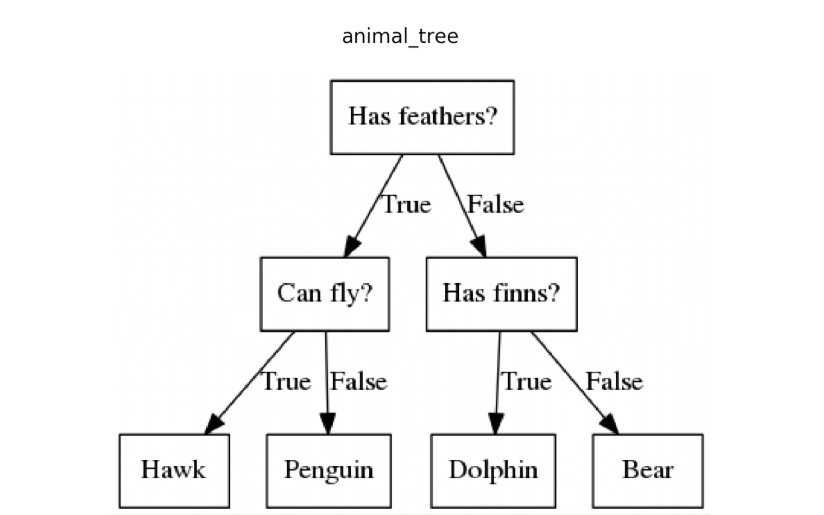

Let's import the `DecisionTreeRegressor` (a decision tree for regression problems) and instantiate it with the default parameters:

In [124]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

To train our model, we use the `.fit` method and give it our training set X and y:

In [126]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

That's it, now we have a trained model that can be used to generate predictions.

If we use the `predict` method we can generate predictions for any practice in our test dataset. Let's try with a row at random:

In [129]:
idx = 10

practice = X_test.iloc[[idx]]
practice

,Number of Registered Patients (Last Known Figure),NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,NHS England (Region) Name_LONDON COMMISSIONING REGION,NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,NHS England (Region) Name_NORTH WEST COMMISSIONING REGION,NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,NHS England (Region) Name_SOUTH WEST COMMISSIONING REGION,Contract Type_APMS,Contract Type_GMS,Contract Type_PMS,Contract Type_UNKNOWN,Practice type_GP practice,Practice type_Walk in and out of hours centre,Practice type_Walk in centre,Practice Rurality_Missing,Practice Rurality_Rural,Practice Rurality_Urban,Number of Days since Opened
4295,4805.25,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,8365


In [130]:
actual = y_test.iloc[idx]
print("Actual payment: {}".format(actual))

Actual payment: 519101.48


In [131]:
# Generate prediction
prediction = model.predict(practice)[0]

print("Prediction: {}".format(prediction))
print("Difference: {}".format(100*abs(actual-prediction)/actual))

Prediction: 592520.95
Difference: 14.143567843420515


This is for just one value, but we can use predict to generate predictions for all the rows in `X_test`:

In [132]:
y_pred = model.predict(X_test)

`scikit-learn` also provides functions to compute useful metrics. Those can be use to evaluate how good our model is on the test set. 

Here we will compute the [`Mean absolute error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html), which tells us, on average, by how much our model is wrong. We can also express it as a percentage to make it easier to estimate how good/bad we are doing.

In [133]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [134]:
mean_absolute_error(y_pred, y_test)

352068.70135676494

In [135]:
mean_absolute_percentage_error(y_pred, y_test)

28.980060314735002

On average, our model is wrong by ~300k (or about ~30%) - this seems pretty bad...

This is likely due to the fact we just used an algorithm out of the box without tuning it. 

Most algorithms take parameters as input that allow to constrain the way it learns and avoid [overfitting/underfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765).

For Decision Trees, the main parameters are:
- `max_depth`: the maximal size of our tree. The deepest the most likely it will overfit. Here let's try a short tree with only 86 layers
- `min_sample_split`: the minimal amount of examples to justify creating a new node in our tree. Higher values ensure we do not create binary rules (nodes) for only one example. Let's set it to 10.

In [158]:
model = DecisionTreeRegressor(max_depth=6, min_samples_split=10)

We can now train our model again and see how the error has improved:

In [159]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_absolute_percentage_error(y_pred, y_test)

0.21003732797157942

That's a bit better - but far from perfect. There are multiple ways you can try to improve this:
- Spend more time finding the best parameters for the `DecisionTreeRegressor`. To do so you can use methods such as [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)
- Build more features using features engineering, analyse predictions to see if our model does better/worse for certain practices and spend more time cleaning the data
- Add more data by our dataset to other datasets providing more information about practices
- Use a different [algorithm](https://scikit-learn.org/stable/supervised_learning.html)

Finally, we can visualise our tree:

[Text(1395.0, 489.24, 'Number of Registered Patients (Last Known Figure) <= 11217.25\nsamples = 5289\nvalue = 1448555.56'),
 Text(697.5, 380.52000000000004, 'Number of Registered Patients (Last Known Figure) <= 5991.25\nsamples = 3866\nvalue = 1060045.389'),
 Text(348.75, 271.8, 'Number of Registered Patients (Last Known Figure) <= 4006.375\nsamples = 1746\nvalue = 687822.63'),
 Text(174.375, 163.08000000000004, 'Practice Rurality_Rural <= 0.5\nsamples = 799\nvalue = 504315.128'),
 Text(87.1875, 54.360000000000014, '\n  (...)  \n'),
 Text(261.5625, 54.360000000000014, '\n  (...)  \n'),
 Text(523.125, 163.08000000000004, 'Practice Rurality_Rural <= 0.5\nsamples = 947\nvalue = 842651.029'),
 Text(435.9375, 54.360000000000014, '\n  (...)  \n'),
 Text(610.3125, 54.360000000000014, '\n  (...)  \n'),
 Text(1046.25, 271.8, 'Practice Rurality_Rural <= 0.5\nsamples = 2120\nvalue = 1366602.435'),
 Text(871.875, 163.08000000000004, 'Number of Registered Patients (Last Known Figure) <= 8470.375\ns

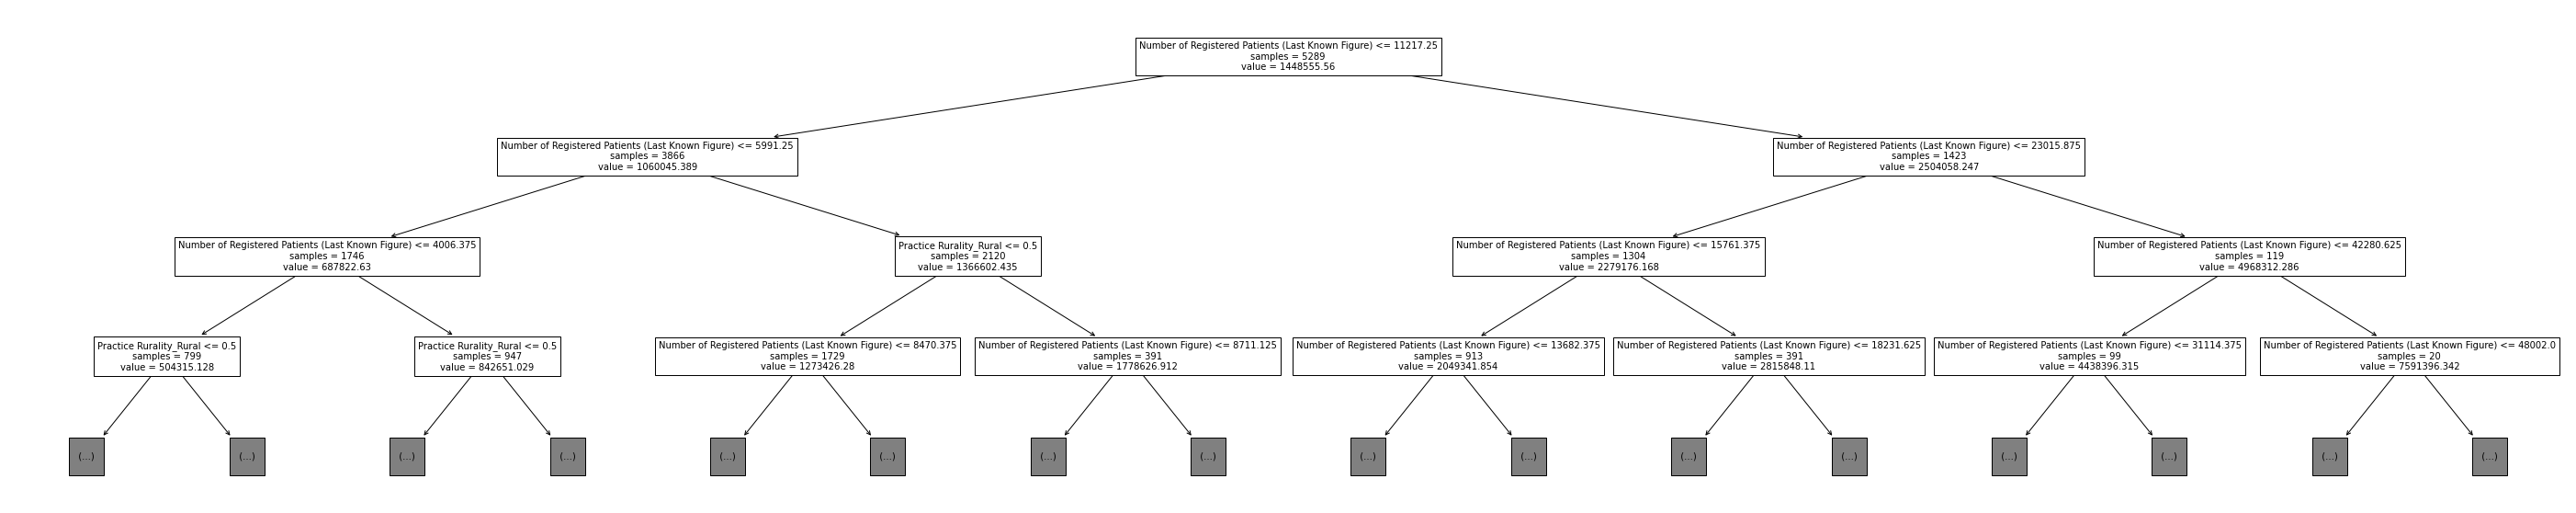

In [176]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(50, 10))
plot_tree(model, max_depth=3, fontsize=10, impurity=False, ax=fig.gca(), feature_names=X.columns)

We can also look at the feature importance:

In [177]:
pd.DataFrame(model.feature_importances_, index=X.columns, 
             columns=["importance"]).sort_values("importance", ascending=False)

,importance
Number of Registered Patients (Last Known Figure),0.944891
Practice Rurality_Rural,0.036626
Number of Days since Opened,0.006566
Practice Rurality_Urban,0.005286
NHS England (Region) Name_NORTH EAST AND YORKSHIRE COMMISSIONING REGION,0.002466
NHS England (Region) Name_SOUTH EAST COMMISSIONING REGION,0.002317
NHS England (Region) Name_LONDON COMMISSIONING REGION,0.000955
NHS England (Region) Name_EAST OF ENGLAND COMMISSIONING REGION,0.000728
Contract Type_GMS,0.000166
NHS England (Region) Name_MIDLANDS COMMISSIONING REGION,0.000000


# 2. Time series problem

    Load data
    train test split (explain diff here not at random)
    Train fbprophet
    explain cross validation is harder (add link)


Dataset is here: https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/

In [264]:
df = pd.read_excel("data/Adjusted-Monthly-AE-Time-Series-October-2021.xls", skiprows=17, parse_dates=["Period"])

Here we want to have the date as index, and a column `y` for the value we are trying to predict.

In [197]:
df.set_index("Period", inplace=True)

In [198]:
y = df[["Total Attendances"]]

<AxesSubplot:xlabel='Period'>

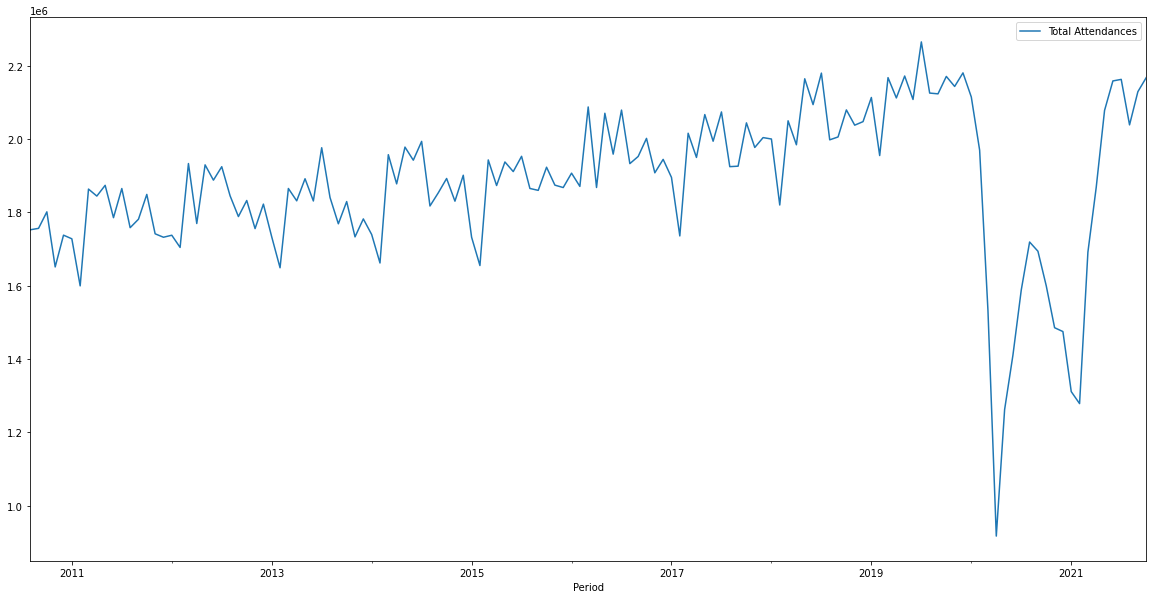

In [199]:
y.plot(figsize=(20, 10))

We can see a big drop in regular attendances in 2020. This is not something our model, which learns about past data only, could have predicted. So for the purpose of this tutorial, we will use:
- Data up to 2018 for training
- Data in 2019 for testing

In [211]:
# Remove data after 2020
y = y[y.index < "2020-01-01"]

# Select y_train and y_test
y_train = y[y.index < "2019-01-01"]
y_test = y[(y.index >= "2019-01-01")]

<AxesSubplot:xlabel='Period'>

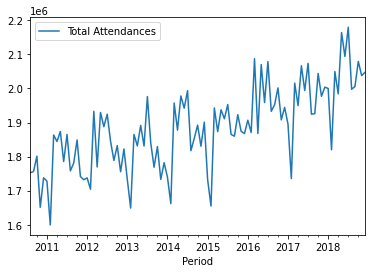

In [214]:
y_train.plot()

<AxesSubplot:xlabel='Period'>

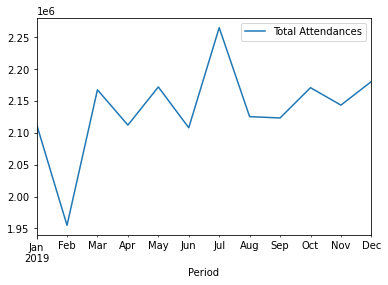

In [215]:
y_test.plot()

Unfortunately time-series are not supported by sklearn, but there exists multiple libraries such as `statsmodels` (which implements ARIMA models) and `keras` (for a Neural Networks approach to time series).

In this tutorial, we will use the [Prophet](https://facebook.github.io/prophet/) library from Facebook to generate forecasts.


In [222]:
from prophet import Prophet

To use prophet we need to modify our dataset so it looks like: 
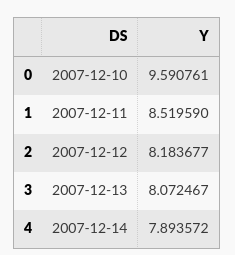

In [227]:
y_train_prophet = y_train.reset_index().rename({"Period": "ds", "Total Attendances": "y"}, axis=1)
y_train_prophet.head()

,ds,y
0,2010-08-01,1.752381e+06
1,2010-09-01,1.756268e+06
2,2010-10-01,1.801348e+06
3,2010-11-01,1.651027e+06
4,2010-12-01,1.737741e+06


In [228]:
y_test_prophet = y_test.reset_index().rename({"Period": "ds", "Total Attendances": "y"}, axis=1)
y_test_prophet

,ds,y
0,2019-01-01,2113413.0
1,2019-02-01,1954947.0
2,2019-03-01,2167551.0
3,2019-04-01,2112165.0
4,2019-05-01,2172006.0
5,2019-06-01,2107987.0
6,2019-07-01,2265050.0
7,2019-08-01,2125435.0
8,2019-09-01,2123345.0
9,2019-10-01,2170885.0


In [229]:
m = Prophet(\)
m.fit(y_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.09078
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99       374.167   9.15615e-05       78.4449      0.8345      0.8345      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       374.335   7.74539e-05       78.3839           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       374.339   6.65209e-09       77.4339       0.356           1      346   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Generate predictions

In [243]:
predictions = m.predict(y_test_prophet[["ds"]])

In [244]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,2.083245e+06,1.952931e+06,2.037438e+06,2.083237e+06,2.083250e+06,-87697.260024,-87697.260024,-87697.260024,-87697.260024,-87697.260024,-87697.260024,0.0,0.0,0.0,1.995548e+06
1,2019-02-01,2.087463e+06,1.873343e+06,1.954092e+06,2.087394e+06,2.087525e+06,-173637.857047,-173637.857047,-173637.857047,-173637.857047,-173637.857047,-173637.857047,0.0,0.0,0.0,1.913825e+06
2,2019-03-01,2.091273e+06,2.067951e+06,2.150965e+06,2.091120e+06,2.091420e+06,20026.561555,20026.561555,20026.561555,20026.561555,20026.561555,20026.561555,0.0,0.0,0.0,2.111300e+06
3,2019-04-01,2.095491e+06,2.055703e+06,2.136554e+06,2.095226e+06,2.095772e+06,-653.667834,-653.667834,-653.667834,-653.667834,-653.667834,-653.667834,0.0,0.0,0.0,2.094838e+06
4,2019-05-01,2.099574e+06,2.126313e+06,2.209708e+06,2.099175e+06,2.100006e+06,67752.072702,67752.072702,67752.072702,67752.072702,67752.072702,67752.072702,0.0,0.0,0.0,2.167326e+06
5,2019-06-01,2.103792e+06,2.079737e+06,2.163629e+06,2.103242e+06,2.104372e+06,19481.584608,19481.584608,19481.584608,19481.584608,19481.584608,19481.584608,0.0,0.0,0.0,2.123273e+06
6,2019-07-01,2.107874e+06,2.155848e+06,2.235583e+06,2.107160e+06,2.108622e+06,85728.007192,85728.007192,85728.007192,85728.007192,85728.007192,85728.007192,0.0,0.0,0.0,2.193602e+06
7,2019-08-01,2.112092e+06,2.024705e+06,2.102354e+06,2.111196e+06,2.113062e+06,-47899.805565,-47899.805565,-47899.805565,-47899.805565,-47899.805565,-47899.805565,0.0,0.0,0.0,2.064193e+06
8,2019-09-01,2.116311e+06,2.037015e+06,2.117689e+06,2.115212e+06,2.117513e+06,-38702.065660,-38702.065660,-38702.065660,-38702.065660,-38702.065660,-38702.065660,0.0,0.0,0.0,2.077609e+06
9,2019-10-01,2.120393e+06,2.099402e+06,2.175554e+06,2.119140e+06,2.121751e+06,16490.558821,16490.558821,16490.558821,16490.558821,16490.558821,16490.558821,0.0,0.0,0.0,2.136883e+06


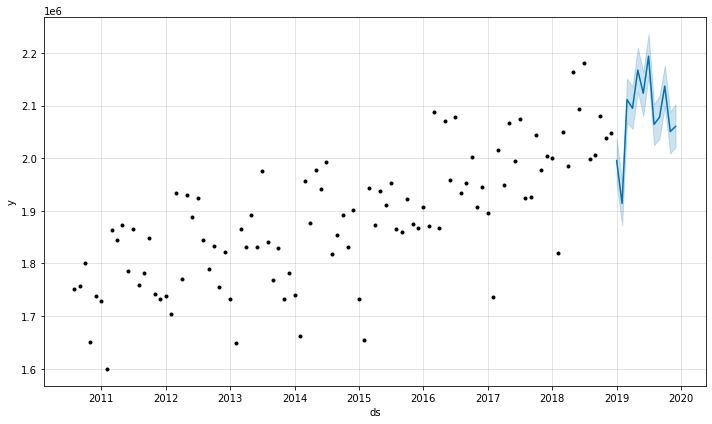

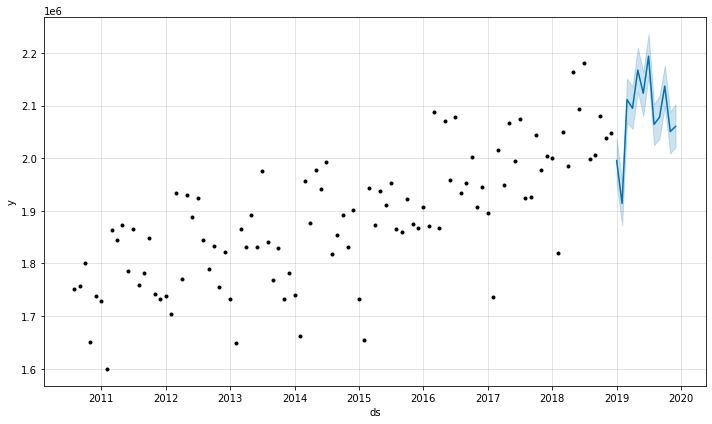

In [259]:
m.plot(predictions)

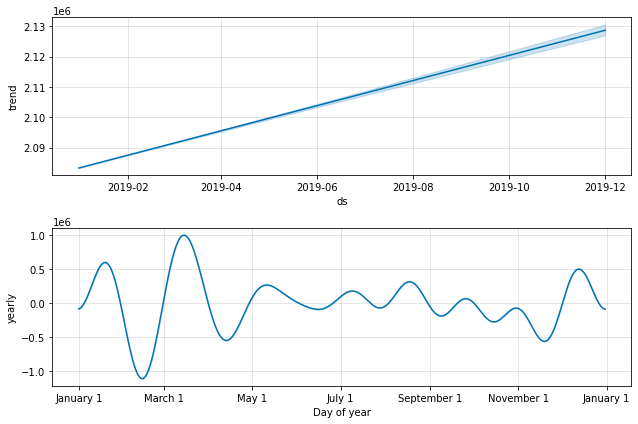

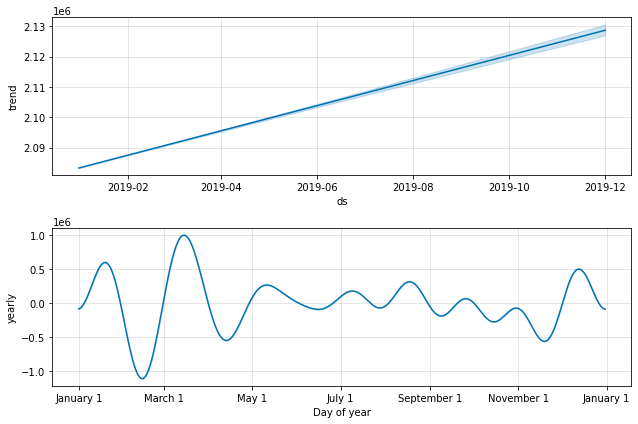

In [260]:
m.plot_components(predictions)

Let's put all in one dataframe for anaylise

In [253]:
result = pd.concat([y_train_prophet, y_test_prophet]).set_index("ds")
result["y_pred"] = predictions.set_index("ds")["yhat"]

result

,y,y_pred
ds,,
2010-08-01,1.752381e+06,NaN
2010-09-01,1.756268e+06,NaN
2010-10-01,1.801348e+06,NaN
2010-11-01,1.651027e+06,NaN
2010-12-01,1.737741e+06,NaN
...,...,...
2019-08-01,2.125435e+06,2.064193e+06
2019-09-01,2.123345e+06,2.077609e+06
2019-10-01,2.170885e+06,2.136883e+06


<AxesSubplot:xlabel='ds'>

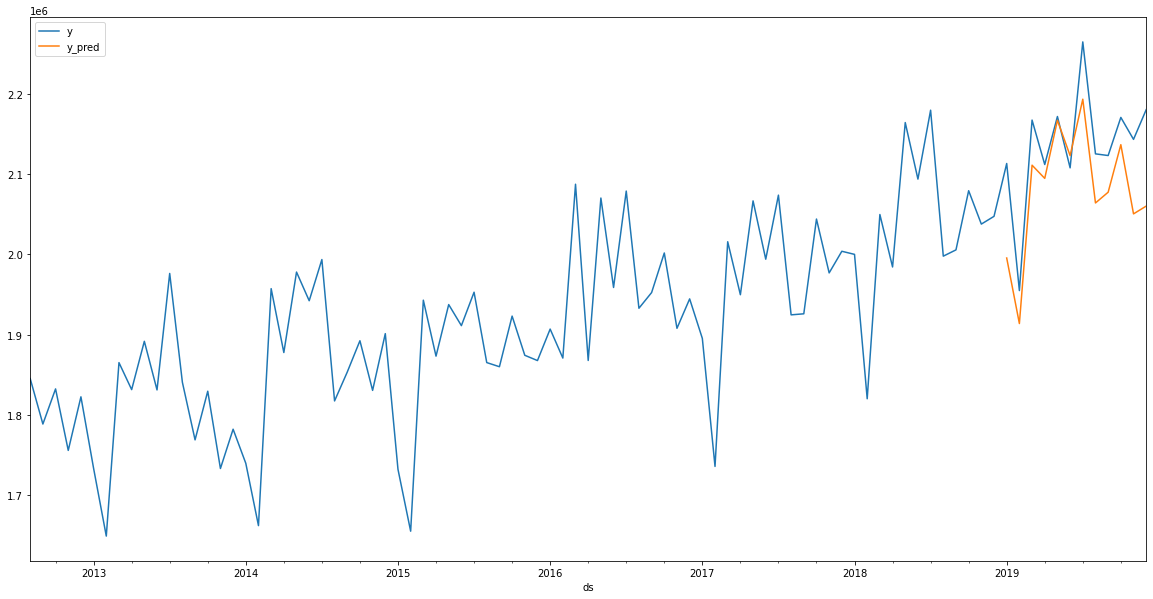

In [257]:
result[24:].plot(figsize=(20, 10))

we can use sklearn to compute the mean absolute error:

In [261]:
mean_absolute_error(predictions["yhat"], y_test_prophet["y"])

56509.85446599702

In [263]:
mean_absolute_percentage_error(predictions["yhat"], y_test_prophet["y"])

0.02738858790441623

We can improve this result by:
- Tuning the model better. We can add holidays, additional seasonality and [more](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). 
- Use [Time series cross validation](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9) to tune and estimate performance
- Use different models such as ARIMA (from `statsmodels`) or neural networks as RNN/LSTM (using `keras)
- Add more data - either more years of the same data or features that correlate with our output and can help predicting it (weather data, etc..)